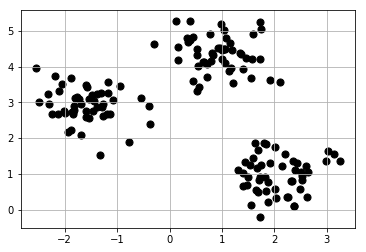

In [1]:
# Grouping objects by similarity using k-means
# Prototype-based clustering - Each cluster represented by a prototype (centroid or medoid)
# Centroid - average [continuous features]
# Medoid - most representative or most frequently occuring point [categorical features]
# Have to specify number of clusters a priori

# create 2D dataset, grouped into 3 regions
from sklearn.datasets import make_blobs
X, y = make_blobs(n_samples=150,
                  n_features=2,
                  centers=3,
                  cluster_std=0.5,
                  shuffle=True,
                  random_state=0)

import matplotlib.pyplot as plt
plt.scatter(X[:,0],
           X[:,1],
           c='black',
           marker='o',
           s=50)

plt.grid()
plt.show()

In [2]:
# K-means algorithm

# 1. Randomly pick k centroids from the sample points as initial cluster centers.
# 2. Assign each sample to the nearest centroid
# 3. Change the centroids to the center of the samples that were assigned to it
# 4. Repeat steps 2 and 3 until cluster assignments do not change or user-defined tolerance / max iterations reached.

# Common used distance for clustering - squared Euclidean distnace between 2 points in m-dimensional space
# Goal is thus to minimize within cluster sum of squared errors (SSE) a.k.a cluster inertia

from sklearn.cluster import KMeans
km = KMeans(n_clusters=3, # desired clusters
           init='random',
           n_init=10, # run k-means 10 times independently with different random centroids
           max_iter=300, # max iterations for single run
           tol=1e-04, # distance tolerance, converge if less than this value
           random_state=0)
y_km = km.fit_predict(X)

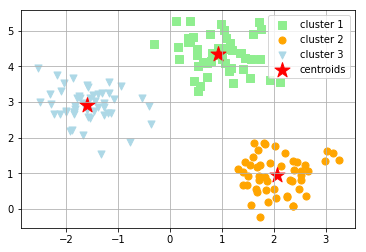

In [3]:
# K-means++

# Random initialization of centroids can result in bad clusterings or slow convergence
# K-means++ - place initial centroids far away from each other via the k-means++ algorithm

# 1. Initialize empty set M to store k centroids.
# 2. Randomly choose first centroid and assign to M.
# 3. For each sample x^i that is not in M, find minimum squared distance to any of the centroids in M.
# 4. Randomly select next centroid using weighted probability - prioritize sample with largest min squared dist.
# 5. Repeat step 2 and 3 until k centroids chosen.
# 6. Proceed with k-means.

# To use k-means++ with scikit-learn's KMeans object, set init parameter to k-means (default) instead of random

# Note: if applying k-means to real-world data using Euclidean distance metric - make sure features are measured
# on the same scale (apply z-score standardization or min-max)

# Visualize clusters
plt.scatter(X[y_km==0,0],
           X[y_km==0,1],
           s=50,
           c='lightgreen',
           marker='s',
           label='cluster 1')
plt.scatter(X[y_km==1,0],
           X[y_km==1,1],
           s=50,
           c='orange',
           marker='o',
           label='cluster 2')
plt.scatter(X[y_km==2,0],
           X[y_km==2,1],
           s=50,
           c='lightblue',
           marker='v',
           label='cluster 3')
plt.scatter(km.cluster_centers_[:,0],
           km.cluster_centers_[:,1],
           s=250,
           marker='*',
           c='red',
           label='centroids')
plt.legend()
plt.grid()
plt.show()

# Other drawbacks of k-means:
# Clusters do not overlap and are not hierarchical
# Assume that there is at least one item in each cluster

In [4]:
# Hard vs soft clustering

# Hard clustering - each sample in a dataset is assigned to exactly one cluster
# Soft clustering - assign a sample to one or more clusters

# Example of soft clustering - Fuzzy C-means (FCM) algorithm
# Replace hard cluster assignment of k-means with probabilities for each point belonging to each cluster

# 1. Specify the number of k centroids and randomly assign the cluster memberships for each point.
# 2. Compute the cluster centroids.
# 3. Update the cluster memberships for each point.
# 4. Repeat steps 2 and 3 until the membership coefficients do not change or a user-defined tolerance or max no.
# of iterations is reached.

# Objective function of FCM:
# Just like within cluster sum-squared-error, except weighted by membership probabilities.
# Add exponent m [1, infinity) to probability, the larger m, the smaller the cluster membership, greater fuzziness
# - fuzziness coefficient
# Refer to textbook for details

In [5]:
# Using the elbow method to find the optimal number of clusters

# Within-cluster SSE (distortion)
print('Distortion: %.2f' % km.inertia_)

Distortion: 72.48


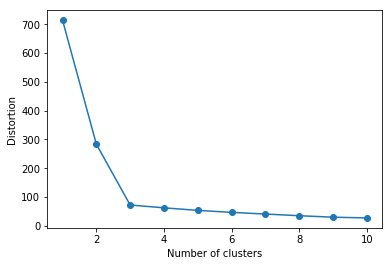

In [6]:
# Estimate optimal number of clusters k for a given task using elbow method
# If k increases, distortion expected to decrease - samples closer to assigned centroids
# Identify value of k where distortion begins to increase most rapidly

distortions = []
for i in range(1, 11):
    km = KMeans(n_clusters=i, 
               init='k-means++',
               n_init=10,
               max_iter=300,
               random_state=0)
    km.fit(X)
    distortions.append(km.inertia_)
plt.plot(range(1,11), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()

# Elbow at k = 3

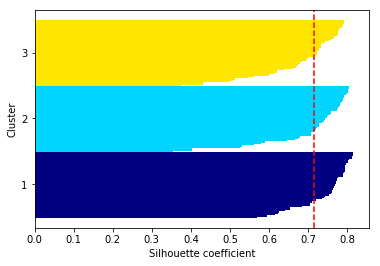

In [7]:
# Quantifying the quality of clustering via silhouette plots

# To calculate silhouette coefficient:
# 1. Calculate the cluster cohesion a(i) as the average distance between a sample x(i) and all other points in the same
# cluster.
# 2. Calculate the cluster separation b(i) from the next closest cluster as the average distance between the sample x(i)
# and all samples in the nearest cluster.
# 3. Calculate the silhouette s(i) as the difference between cluster cohesion and separation divided by the greater
# of two

# Silhouette coefficients is bounded in range -1 to 1.
# 0 if cluster separation and cohesion are equal, closer to 1 if separation >> cohesion

km = KMeans(n_clusters=3,
           init='k-means++',
            n_init=10,
            max_iter=300,
            tol=1e-04,
            random_state=0)
y_km = km.fit_predict(X)

import numpy as np
from matplotlib import cm
from sklearn.metrics import silhouette_samples
cluster_labels = np.unique(y_km)
n_clusters = cluster_labels.shape[0]
silhouette_vals = silhouette_samples(X, y_km, metric='euclidean')

y_ax_lower, y_ax_upper = 0, 0
yticks = []
for i, c in enumerate(cluster_labels):
    c_silhouette_vals = silhouette_vals[y_km == c]
    c_silhouette_vals.sort()
    y_ax_upper += len(c_silhouette_vals)
    color = cm.jet(i / n_clusters)
    plt.barh(range(y_ax_lower, y_ax_upper),
            c_silhouette_vals,
            height=1.0,
            edgecolor='none',
            color=color)
    yticks.append((y_ax_lower + y_ax_upper) / 2)
    y_ax_lower += len(c_silhouette_vals)
silhouette_avg = np.mean(silhouette_vals)
plt.axvline(silhouette_avg,
           color='red',
           linestyle='--')
plt.yticks(yticks, cluster_labels + 1)
plt.ylabel('Cluster')
plt.xlabel('Silhouette coefficient')
plt.show()

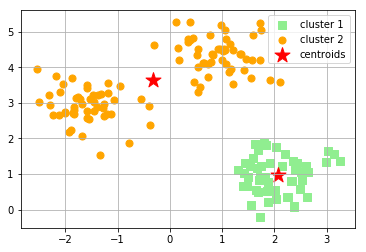

In [8]:
# bad clustering
km = KMeans(n_clusters=2,
           init='k-means++',
           n_init=10,
           max_iter=300,
           tol=1e-04,
           random_state=0)
y_km = km.fit_predict(X)

plt.scatter(X[y_km==0,0],
           X[y_km==0,1],
           s=50, c='lightgreen',
           marker='s',
           label='cluster 1')
plt.scatter(X[y_km==1,0],
           X[y_km==1,1],
           s=50,
           c='orange',
           marker='o',
           label='cluster 2')
plt.scatter(km.cluster_centers_[:,0],
           km.cluster_centers_[:,1],
           s=250,
           marker='*',
           c='red',
           label='centroids')
plt.legend()
plt.grid()
plt.show()

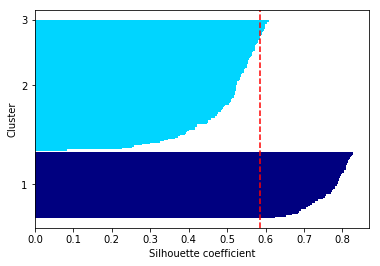

In [9]:
# silhouette plot to evaluate results
clusters_labels = np.unique(y_km)
n_clusters = cluster_labels.shape[0]
silhouette_vals = silhouette_samples(X, y_km, metric='euclidean')
y_ax_lower, y_ax_upper = 0, 0
yticks = []
for i, c in enumerate(cluster_labels):
    c_silhouette_vals = silhouette_vals[y_km == c]
    c_silhouette_vals.sort()
    y_ax_upper += len(c_silhouette_vals)
    color = cm.jet(i / n_clusters)
    plt.barh(range(y_ax_lower, y_ax_upper),
            c_silhouette_vals,
            height=1.0,
            edgecolor='none',
            color=color)
    yticks.append((y_ax_lower + y_ax_upper) / 2)
    y_ax_lower += len(c_silhouette_vals)
silhouette_avg = np.mean(silhouette_vals)
plt.axvline(silhouette_avg, color='red', linestyle='--')
plt.yticks(yticks, cluster_labels + 1)
plt.ylabel('Cluster')
plt.xlabel('Silhouette coefficient')
plt.show()

In [13]:
# Organizing clusters as a hierarchical tree
# Alternative to prototype-based clustering
# Two main approaches to hierarchical clustering: agglomerative and divisive hierarchical clustering
# 1. Divisive hierarchical clustering: Start with one claster that encompass all samples, then iteratively split into
# smaller clusters until each cluster only contains one sample.
# 2. Agglomerative clustering: Start with each sample as an individual cluster and merge the closest pairs of clusters
# until only one cluster remains.

# Two standard algorithms for agglomerative hierarchical clustering:
# 1. Single linkage - commpute distances between most similar members for each pair of clusters and merge the two
# clusters for which the distance between the most similar members is the smallest.
# 2. Complete linkage - same as single linkage but compare the most dissimilar members to perform merge

# Agglomerative clustering using complete linkage approach:
# 1. Compute the distance matrix of all samples
# 2. Represent each data point as a single cluster
# 3. Merge two closest clusters based on distance of most dissimilar(distant) members
# 4. Update the distance matrix.
# 5. Repeat steps 2 to 4 until one single cluster remains

# Generate random sample data to work with:
import pandas as pd
import numpy as np
np.random.seed(123)
variables = ['X', 'Y', 'Z']
labels = ['ID_0', 'ID_1', 'ID_2', 'ID_3', 'ID_4']
X = np.random.random_sample([5,3])*10
df = pd.DataFrame(X, columns=variables, index=labels)
df

,X,Y,Z
ID_0,6.964692,2.861393,2.268515
ID_1,5.513148,7.194690,4.231065
ID_2,9.807642,6.848297,4.809319
ID_3,3.921175,3.431780,7.290497
ID_4,4.385722,0.596779,3.980443


In [16]:
# Performing hierarchical clustering on a distance matrix
from scipy.spatial.distance import pdist, squareform
row_dist = pd.DataFrame(squareform(pdist(df, metric='euclidean')),
                       columns=labels, index=labels)
row_dist

,ID_0,ID_1,ID_2,ID_3,ID_4
ID_0,0.000000,4.973534,5.516653,5.899885,3.835396
ID_1,4.973534,0.000000,4.347073,5.104311,6.698233
ID_2,5.516653,4.347073,0.000000,7.244262,8.316594
ID_3,5.899885,5.104311,7.244262,0.000000,4.382864
ID_4,3.835396,6.698233,8.316594,4.382864,0.000000


In [20]:
# apply complete linkage agglomeration
from scipy.cluster.hierarchy import linkage
row_clusters = linkage(pdist(df, metric='euclidean'),
                      method='complete')
# Alternatively:
# row_clusters = linkage(df.values, method='complete, metric='euclidean')

In [21]:
# Clustering results
pd.DataFrame(row_clusters,
            columns=['row label 1',
                    'row label 2',
                    'distance',
                    'no. of items in clust.'],
            index=['cluster %d' %(i+1) for i in range(row_clusters.shape[0])])

# Each row represents one merge
# label 1 and 2 represent most disimilar members and their distances

,row label 1,row label 2,distance,no. of items in clust.
cluster 1,0.0,4.0,3.835396,2.0
cluster 2,1.0,2.0,4.347073,2.0
cluster 3,3.0,5.0,5.899885,3.0
cluster 4,6.0,7.0,8.316594,5.0


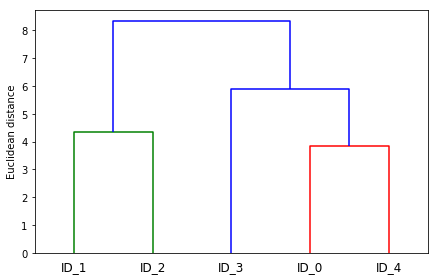

In [23]:
# Visualize results in dendrogram
from scipy.cluster.hierarchy import dendrogram
# make dendrogram black (part 1/2)
# from scipy.cluster.hierarchy import set_link_color_palette
# set_link_color_palette(['black'])
row_dendr = dendrogram(row_clusters,
                     labels=labels,
                     # make dendogram black (part 2/2)
                    # color_threshold=np.inf
                     )
plt.tight_layout()
plt.ylabel('Euclidean distance')
plt.show()

In [38]:
# Attaching dendrograms to a heat map
# 1. Create new figure object and define the x axis position, y axis position, width and height of the dendrogram via
# add_axes attribute
fig = plt.figure(figsize=(8,8), facecolor='white')
axd = fig.add_axes([0.09, 0.1, 0.2, 0.6]) # x, y, width, height
row_dendr = dendrogram(row_clusters, orientation='right')

In [39]:
# Reorder data in initial DataFrame according to clustering labels accessed via 'leaves' key
df_rowclust = df.ix[row_dendr['leaves'][::-1]]

In [40]:
# Construct heat map from the reordered DataFrame and position it right next to the dendrogram:
axm = fig.add_axes([0.23, 0.1, 0.6, 0.6]) # x, y, width, height
cax = axm.matshow(df_rowclust, interpolation='nearest', cmap='hot_r')

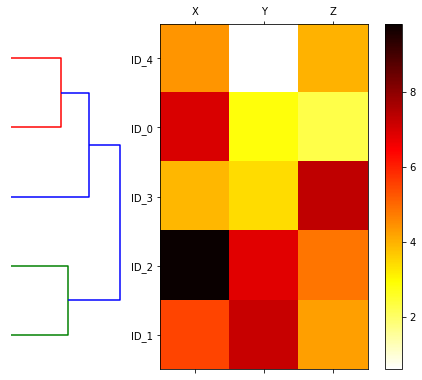

In [41]:
# Modify aesthetics of heat map
axd.set_xticks([])
axd.set_yticks([])
for i in axd.spines.values(): # hide spine axis (frame)
    i.set_visible(False)
fig.colorbar(cax)
axm.set_xticklabels([''] + list(df_rowclust.columns))
axm.set_yticklabels([''] + list(df_rowclust.index))
plt.show()

In [42]:
# Applying agglomerative clustering via scikit-learn
from sklearn.cluster import AgglomerativeClustering
ac = AgglomerativeClustering(n_clusters=2, # choose the number of clusters to return
                            affinity='euclidean',
                            linkage='complete')
labels = ac.fit_predict(X)
print('Cluster labels: %s' % labels)

Cluster labels: [0 1 1 0 0]


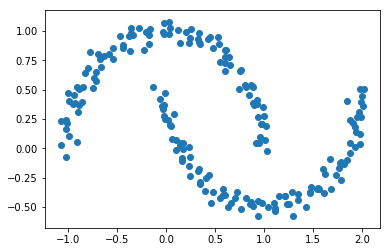

In [45]:
# Locating regions of high density via Density-based Spatial Clustering of Applications with Noise (DBSCAN)

# A special label is assigned to each sample using the following criteria:
# 1. A point is a core point if at least a specified number (MinPts) of neighboring points fall within the specified
# radius e
# 2. A border point is a point that has fewer neighbors than MinPts within e, but lies within the e radius of a core point
# 3. All other points are noise points

# After labeling points, DBSCAN proceeds as follows:
# 1. Form a separate cluster for each core point or a connected group of core points (connected means no farther away
# than e).
# 2. Assign each border point to the cluster of its corresponding core point.

# Advantage of DBSCAN:
# Does not assume clusters have spherical shape (as in k-means).
# Does not assign every point to a cluster - can remove noise points

# Disadvantages of DBSCAN
# With an increasing number of features in dataset given fixed size training set - curse of dimensionality (this affects
# any clustering algorithm that uses euclidean distance)
# Two hyperparameters MinPts and e that needs to be optmized to get good clstering results

# create dataset to compare clustering algorithms
from sklearn.datasets import make_moons
X, y = make_moons(n_samples=200,
                 noise=0.05,
                 random_state=0)
plt.scatter(X[:,0], X[:,1])
plt.show()

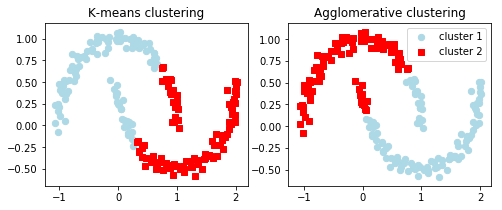

In [49]:
# k-means clustering 
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,3))
km = KMeans(n_clusters=2,
           random_state=0)
y_km = km.fit_predict(X)
ax1.scatter(X[y_km==0,0],
            X[y_km==0,1],
            c='lightblue',
            marker='o',
            s=40,
            label='cluster 1')
ax1.scatter(X[y_km==1,0],
           X[y_km==1,1],
           c='red',
           marker='s',
           s=40,
           label='cluster 2')
ax1.set_title('K-means clustering')

# agglomerative clustering with complete linkage
ac = AgglomerativeClustering(n_clusters=2,
                            affinity='euclidean',
                            linkage='complete')
y_ac = ac.fit_predict(X)
ax2.scatter(X[y_ac==0,0],
           X[y_ac==0,1],
           c='lightblue',
           marker='o',
           s=40,
           label='cluster 1')
ax2.scatter(X[y_ac==1,0],
            X[y_ac==1,1],
            c='red',
            marker='s',
            s=40,
            label='cluster 2')
ax2.set_title('Agglomerative clustering')
plt.legend()
plt.show()

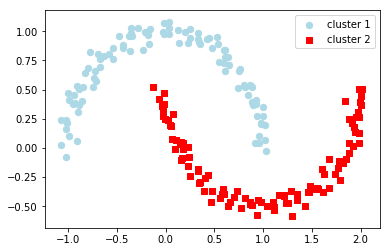

In [53]:
# DBSCAN algorithm
from sklearn.cluster import DBSCAN
db = DBSCAN(eps=0.2,
           min_samples=5,
           metric='euclidean')
y_db = db.fit_predict(X)
plt.scatter(X[y_db==0,0],
           X[y_db==0,1],
           c='lightblue',
           marker='o',
           s=40,
           label='cluster 1')
plt.scatter(X[y_db==1,0],
           X[y_db==1,1],
           c='red',
           marker='s',
           s=40,
           label='cluster 2')
plt.legend()
plt.show()